# SF Crime PSET 1

1. [Introduction](#intro)
2. [Getting the Data](#data)
3. [Descriptive Statistics](#stats)
4. [Geographic Information Systems](#gis)
5. [Discussion Questions](#dq)

In [1]:
# imports
import requests
from datascience import *
import matplotlib.pyplot as plt
import datetime
import folium
from folium import GeoJson
import time
import json
import os
from branca.colormap import linear
import branca.colormap
import pandas as pd
%matplotlib inline

## 1. Introduction <a id='intro'></a>

For this lab, we will be working with the San Francisco Police Department's Incident Database. The dataset contains up-to-date information on incidents reported to the SFPD. Each observation is tagged with information about the incident's location, type of infraaction, and date/time. In this lab you will:

1. Download the data through an Application Programming Interface (API)
2. Explore the data with summary and descriptive statistics
3. Map the incidents

Make sure to start early and ask lots of questions! The dataset, along with other publicaly available data, is available at: https://data.sfgov.org/Public-Safety/Police-Department-Incidents/tmnf-yvry

## 2. Getting the Data <a id='data'></a>

Write code that pulls the data into your environment with an API call. Here is the link to the API: https://data.sfgov.org/resource/PdId.json

In [19]:
sf_police = os.path.join('po_department_incidents.csv')
df = pd.read_csv(sf_police)

In [2]:
# the url that we want to get our data from
#
#  ******* THIS IS THE OLD DATA PULLING CELL. DO NOT USE. USE CELL BELOW. *******
data_url = 'https://data.sfgov.org/resource/PdId.json?$limit=1&$offset=0&$order=date DESC'

# making our http request to DATA_URL
response = requests.get(data_url)
# using the built-in json decoder of the requests library to interpret the text
json_response = response.json()
len(json_response)

1

In [3]:
#ts = Table(data.labels)
offset = 0
n = 2
recs = []
while n > 0:
    print(n)
    lnk = 'https://data.sfgov.org/resource/PdId.json?$limit=50000&$offset={}&$order=date DESC'.format(str(offset))
    r = requests.get(lnk)
    js = r.json()
    recs.extend(js)
    offset += 50000
    n -= 1
len(recs)

2
1


100000

In [20]:
import pandas as pd
df = pd.DataFrame(recs)
df.head()

NameError: name 'recs' is not defined

In [21]:
data = Table.from_df(df.drop('location', axis=1))
data

incidntnum,category,descript,dayofweek,date,time,pddistrict,resolution,address,x,y,pdid
150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.422,37.7617,1.5006e+13
150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,02/01/2015,15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414,37.7842,1.50098e+13
150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,02/01/2015,15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414,37.7842,1.50098e+13
150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,02/01/2015,15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414,37.7842,1.50098e+13
150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,01/27/2015,19:00:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431,37.8005,1.50098e+13
150098232,NON-CRIMINAL,AIDED CASE -PROPERTY FOR DESTRUCTION,Sunday,02/01/2015,16:21:00,RICHMOND,NONE,400 Block of LOCUST ST,-122.452,37.7871,1.50098e+13
150098248,SECONDARY CODES,DOMESTIC VIOLENCE,Saturday,01/31/2015,21:00:00,BAYVIEW,NONE,700 Block of KIRKWOOD AV,-122.374,37.7292,1.50098e+13
150098248,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM",Saturday,01/31/2015,21:00:00,BAYVIEW,NONE,700 Block of KIRKWOOD AV,-122.374,37.7292,1.50098e+13
150098254,BURGLARY,"BURGLARY OF STORE, UNLAWFUL ENTRY",Saturday,01/31/2015,16:09:00,CENTRAL,NONE,200 Block of STOCKTON ST,-122.407,37.7878,1.50098e+13
150098260,LARCENY/THEFT,PETTY THEFT SHOPLIFTING,Saturday,01/31/2015,17:00:00,CENTRAL,NONE,800 Block of GEARY ST,-122.417,37.7863,1.50098e+13


In [22]:
min(df['date'])

'01/01/2003'

In [23]:
# making a table out of our json
# DO NOT USE 
#data = Table.from_records(json_response)
#data.show(3)

In [26]:
data['y'] = data['y'].astype('float')
data['x'] = data['x'].astype('float')

<font color='blue'><b>QUESTION: What are the advantages to downloading data this way, instead of with a point-and-click action?</b></font color>

## 3. Descriptive Statistics <a id='stats'></a>

Plot the number of incidents per year from 2000-2017 (choose the appropriate type of plot). Have crime rates increased or decreased in general? 

In [29]:
# creating a year column from the first four characters of the 'date' column
data['year'] = pd.DatetimeIndex(df['date']).year
data

incidntnum,category,descript,dayofweek,date,time,pddistrict,resolution,address,x,y,pdid,year
150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.422,37.7617,1.5006e+13,2015
150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,02/01/2015,15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414,37.7842,1.50098e+13,2015
150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,02/01/2015,15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414,37.7842,1.50098e+13,2015
150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,02/01/2015,15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414,37.7842,1.50098e+13,2015
150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,01/27/2015,19:00:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431,37.8005,1.50098e+13,2015
150098232,NON-CRIMINAL,AIDED CASE -PROPERTY FOR DESTRUCTION,Sunday,02/01/2015,16:21:00,RICHMOND,NONE,400 Block of LOCUST ST,-122.452,37.7871,1.50098e+13,2015
150098248,SECONDARY CODES,DOMESTIC VIOLENCE,Saturday,01/31/2015,21:00:00,BAYVIEW,NONE,700 Block of KIRKWOOD AV,-122.374,37.7292,1.50098e+13,2015
150098248,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM",Saturday,01/31/2015,21:00:00,BAYVIEW,NONE,700 Block of KIRKWOOD AV,-122.374,37.7292,1.50098e+13,2015
150098254,BURGLARY,"BURGLARY OF STORE, UNLAWFUL ENTRY",Saturday,01/31/2015,16:09:00,CENTRAL,NONE,200 Block of STOCKTON ST,-122.407,37.7878,1.50098e+13,2015
150098260,LARCENY/THEFT,PETTY THEFT SHOPLIFTING,Saturday,01/31/2015,17:00:00,CENTRAL,NONE,800 Block of GEARY ST,-122.417,37.7863,1.50098e+13,2015


In [30]:
agg_on_year = data.group('year')
agg_on_year.show()

year,count
2003,149176
2004,148148
2005,142186
2006,137853
2007,137639
2008,141311
2009,139860
2010,133523
2011,132697
2012,140847


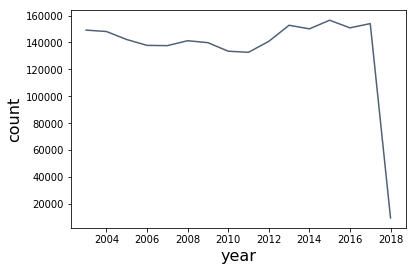

In [31]:
agg_on_year.plot('year', 'count')

Looking just at 2017, what proportion of the total does each type of crime constitute? Use at least one table and at least one plot to support your answer.

In [32]:
agg_by_crime = data.where('year', 2017).group('category')
agg_by_crime['proportion'] = [count / sum(agg_by_crime.column('count')) for count in agg_by_crime.column('count')]
agg_by_crime.sort('proportion', descending=True)

category,count,proportion
LARCENY/THEFT,47687,0.309614
OTHER OFFENSES,18207,0.118211
NON-CRIMINAL,17265,0.112095
ASSAULT,13607,0.0883451
VANDALISM,9744,0.0632641
SUSPICIOUS OCC,6091,0.0395466
BURGLARY,5819,0.0377806
VEHICLE THEFT,5716,0.0371118
WARRANTS,4952,0.0321515
MISSING PERSON,4444,0.0288532


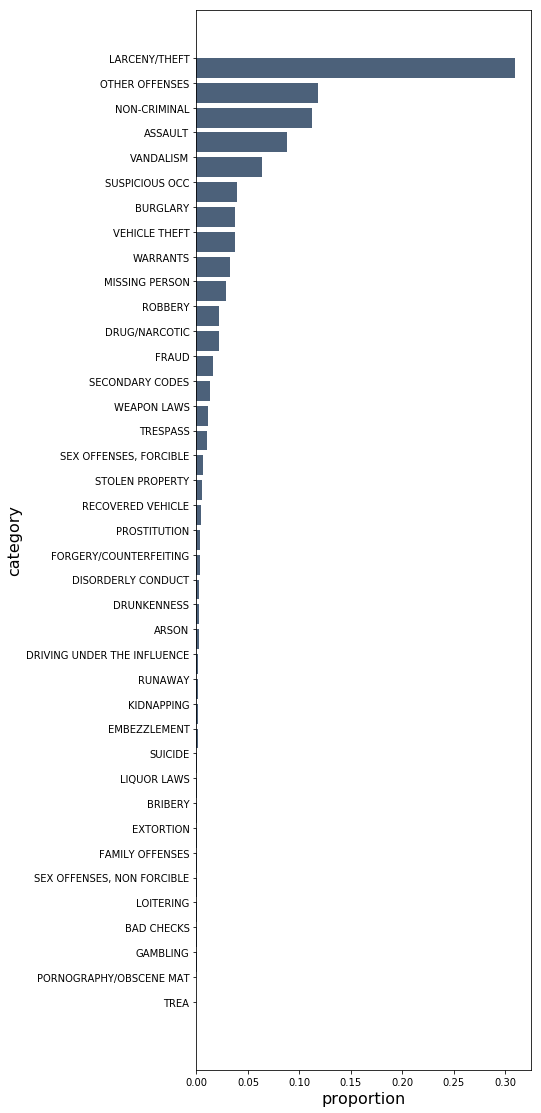

In [33]:
agg_by_crime.sort('count', descending=True).barh('category', 'proportion')

Is there a relationship between day of week, time, and whether an incident occurs? Bonus: Is there a relationship between day/time and particular types of incidents?

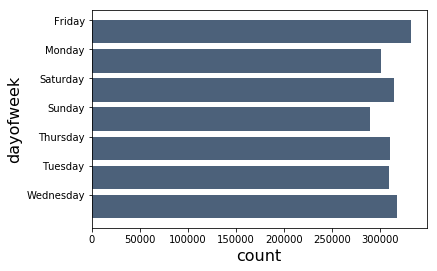

In [34]:
data.group('dayofweek').barh('dayofweek')

In [35]:
# making an hour column that can be grouped on
data['hour'] = [int(t[:2]) for t in data['time']]

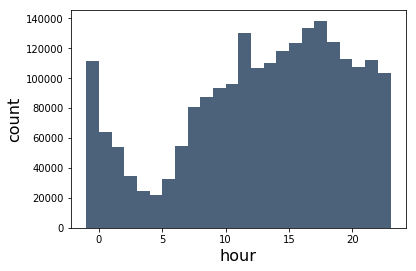

In [36]:
data.group('hour').bar('hour')

#### Bonus: Are there any other interesting relationships in the data?

# 4. Geographic Information Systems (GIS) <a id='gis'></a>

Plot individual incidents in 2017 as points on a map of San Francisco. Does crime seem randomly distributed in space, or do incidents tend to cluster close together? Propose an explanation for your conclusion. Bonus: Shade the points by type of crime.

Hint: Use the `basemap` extension to the `matplotlib` package!

In [37]:
twentyeighteen = data.where('year' == 2017).sample(1000)
twentyeighteen['y'] = twentyeighteen['y'].astype('float')
twentyeighteen['x'] = twentyeighteen['x'].astype('float')

In [38]:
mp = folium.Map(location=[37.7749, -122.4194])
for coords in list(zip(twentyeighteen['y'], twentyeighteen['x'])):
    folium.Marker(
        location=coords
    ).add_to(mp)
mp

In [19]:
from folium.plugins import HeatMap

mp = folium.Map(location=[37.7749, -122.4194])
HeatMap(list(zip(twentyeighteen['y'], twentyeighteen['x']))).add_to(mp)
mp

Merge the incidents data with either a Shapefile or GeoJSON file with information on the boundaries of neighborhoods in San Francisco. 

The neighborhood data is available here: https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h

The API endpoint: https://data.sfgov.org/resource/xfcw-9evu.json

*.geojson

In [20]:
#import requests
#r = requests.get(url='https://data.sfgov.org/resource/xfcw-9evu.json')

In [39]:
sf_neighborhoods = os.path.join('SF Find Neighborhoods.geojson')
geo_json_data = json.load(open(sf_neighborhoods))

In [40]:
m = folium.Map([37.7749, -122.4194], zoom_start = 12)
m

In [41]:
# might be too big bc won't display
m = folium.Map(
    location=[37.7749, -122.4194], zoom_start = 12
)

folium.GeoJson(geo_json_data
).add_to(m)
m

Construct a choropleth map, coloring in each neighborhood by how many incidents it had in 2018. Bonus: Construct several maps that explore differences by day of week, time of year, time of day, etc.

In [42]:
twentyeighteen = twentyeighteen.to_df()

In [43]:
import geopandas as gpd
import shapely
shapely.speedups.enable()

In [44]:
twentyeighteen_spatial_points = gpd.GeoDataFrame(twentyeighteen.drop(['x', 'y'], axis=1),
                       crs={'init': 'epsg:4326'},
                       geometry=twentyeighteen.apply(lambda row: shapely.geometry.Point((row.x, row.y)), axis=1))

In [45]:
sf_polygons = gpd.GeoDataFrame.from_features(geo_json_data['features'])
sf_polygons.crs = {'init' :'epsg:4326'}

In [46]:
sf_spatial = gpd.sjoin(sf_polygons, twentyeighteen_spatial_points, how="inner", op="intersects")

In [47]:
crime_neighborhood = pd.DataFrame(sf_spatial).reset_index()
crime_neighborhood.head(5)

,index,geometry,highlight,link,name,style,index_right,incidntnum,category,descript,dayofweek,date,time,pddistrict,resolution,address,pdid,year,hour
0,1,(POLYGON ((-122.4871507149999 37.7837854270000...,{},None,Lake Street,{},989,126077597,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM",Wednesday,06/06/2012,18:00:00,RICHMOND,NONE,100 Block of 22ND AV,1.260776e+13,2012,18
1,4,(POLYGON ((-122.4726257899999 37.7863148060000...,{},http://www.sfgate.com/neighborhoods/sf/innerri...,Inner Richmond,{},835,170355131,LIQUOR LAWS,POSSESSION OF ALCOHOL BY MINOR,Sunday,04/30/2017,22:41:00,RICHMOND,"ARREST, BOOKED",FULTON ST / 12TH AV,1.703551e+13,2017,22
2,8,(POLYGON ((-122.5131405409999 37.7713311150000...,{},http://www.sfgate.com/neighborhoods/sf/goldeng...,Golden Gate Park,{},835,170355131,LIQUOR LAWS,POSSESSION OF ALCOHOL BY MINOR,Sunday,04/30/2017,22:41:00,RICHMOND,"ARREST, BOOKED",FULTON ST / 12TH AV,1.703551e+13,2017,22
3,4,(POLYGON ((-122.4726257899999 37.7863148060000...,{},http://www.sfgate.com/neighborhoods/sf/innerri...,Inner Richmond,{},194,150313024,LARCENY/THEFT,PETTY THEFT FROM A BUILDING,Friday,04/10/2015,10:00:00,RICHMOND,NONE,700 Block of 8TH AV,1.503130e+13,2015,10
4,4,(POLYGON ((-122.4726257899999 37.7863148060000...,{},http://www.sfgate.com/neighborhoods/sf/innerri...,Inner Richmond,{},28,100826196,OTHER OFFENSES,TAMPERING WITH A VEHICLE,Sunday,09/05/2010,09:30:00,RICHMOND,NONE,CABRILLO ST / 11TH AV,1.008262e+13,2010,9


In [48]:
crime_neighborhood_agg = crime_neighborhood.groupby('name').size().reset_index()
crime_neighborhood_agg.head(5)

,name,0
0,Alamo Square,4
1,Anza Vista,3
2,Apparel City,4
3,Aquatic Park / Ft. Mason,4
4,Bayview,25


In [49]:
crime_neighborhood_agg.columns = ['neighborhood', 'crimes']
crime_neighborhood_agg.head(5)

,neighborhood,crimes
0,Alamo Square,4
1,Anza Vista,3
2,Apparel City,4
3,Aquatic Park / Ft. Mason,4
4,Bayview,25


Do you notice any patters? Are there particular neighborhoods where crime concentrates more heavily?

In [50]:
m = folium.Map(
    location=[37.7749, -122.4194], zoom_start = 12
)

m.choropleth(
    geo_data=geo_json_data,
    data=crime_neighborhood_agg,
    columns=['neighborhood', 'crimes'],
    key_on='feature.properties.name',
    fill_color='OrRd',
    threshold_scale=[10, 60, 100, 140],
    highlight=True
    )

m

# 5. Discussion Questions <a id='dq'></a>

Based on the evidence from this lab assignment, why do you think "hot spots" policing became more popular in the last few decades? What are the pros and cons to this kind of approach?

What other sorts of data would help improve your analysis?

In [51]:
def append_and_follow(t, link, n):
    if n == 0:
        print('Next link (if you want to continue)', link)
        return t
    time.sleep(3)
    print(n)
    r = requests.get(link)
    js = r.json()
    return append_and_follow(t.append(Table.from_records(js['value'])), js['@odata.nextLink'], n-1)

starter = Table(('__id', 'address', 'category', 'date', 'dayofweek', 'descript', 'incidntnum', 
                 'location', 'pddistrict', 'pdid', 'resolution', 'time', 'x', 'y'))
starting_url = 'https://data.sfgov.org/api/odata/v4/tmnf-yvry'

c = append_and_follow(starter, starting_url, 6)
c

6
5
4
3
2
1
Next link (if you want to continue) https://data.sfgov.org/api/odata/v4/tmnf-yvry?$skip=51000&$top=10000


__id,address,category,date,dayofweek,descript,incidntnum,location,pddistrict,pdid,resolution,time,x,y
row-zjqe~xv2z~ekgy,200 Block of DONAHUE ST,RECOVERED VEHICLE,2007-05-18T00:00:00Z,Friday,RECOVERED VEHICLE - STOLEN OUTSIDE SF,070504991,"{'latitude': 37.728408061778, 'longitude': -122.37059079 ...",BAYVIEW,7050499107055,NONE,00:48,-122.371,37.7284
row-v98r~2dn8_imi9,1000 Block of POTRERO AV,LARCENY/THEFT,2017-12-14T00:00:00Z,Thursday,"LOST PROPERTY, GRAND THEFT",180022803,"{'latitude': 37.756486410931, 'longitude': -122.40653911 ...",MISSION,18002280326145,NONE,11:00,-122.407,37.7565
row-9276~qwfr~vcgg,700 Block of JACKSON ST,FRAUD,2017-12-09T00:00:00Z,Saturday,FRAUDULENT USE OF AUTOMATED TELLER CARD,180022643,"{'latitude': 37.796008010259, 'longitude': -122.40722845 ...",CENTRAL,18002264309250,NONE,10:00,-122.407,37.796
row-t77e_qgcd.yaev,JESSIE ST / 5TH ST,LARCENY/THEFT,2017-12-31T00:00:00Z,Sunday,GRAND THEFT OF PROPERTY,186000663,"{'latitude': 37.783291716654, 'longitude': -122.40718855 ...",SOUTHERN,18600066306374,NONE,17:30,-122.407,37.7833
row-7pux_xr7p_982c,400 Block of GEARY ST,ASSAULT,2017-12-31T00:00:00Z,Sunday,AGGRAVATED ASSAULT WITH A DEADLY WEAPON,180000144,"{'latitude': 37.786988188531, 'longitude': -122.41069965 ...",CENTRAL,18000014404013,"ARREST, BOOKED",23:35,-122.411,37.787
row-6hx6-fzf7.smnx,WEBSTER ST / HAIGHT ST,NON-CRIMINAL,2017-12-31T00:00:00Z,Sunday,"LICENSE PLATE, RECOVERED",180011969,"{'latitude': 37.772314968472, 'longitude': -122.42880508 ...",NORTHERN,18001196971012,NONE,15:00,-122.429,37.7723
row-sawf-s5fg.rdp2,1200 Block of POLK ST,LARCENY/THEFT,2017-12-31T00:00:00Z,Sunday,GRAND THEFT PICKPOCKET,180001932,"{'latitude': 37.788452157813, 'longitude': -122.42032699 ...",NORTHERN,18000193206111,NONE,11:20,-122.42,37.7885
row-de85_kr7a-kjh7,BROADWAY ST / BUCHANAN ST,LARCENY/THEFT,2017-12-04T00:00:00Z,Monday,PETTY THEFT OF PROPERTY,176330806,"{'latitude': 37.794683470714, 'longitude': -122.43163617 ...",NORTHERN,17633080606372,NONE,01:15,-122.432,37.7947
row-8vb7~mss3_2t39,400 Block of 18TH AV,LARCENY/THEFT,2017-12-28T00:00:00Z,Thursday,GRAND THEFT FROM LOCKED AUTO,176340855,"{'latitude': 37.779450724398, 'longitude': -122.47723762 ...",RICHMOND,17634085506244,NONE,20:00,-122.477,37.7795
row-5jn4~verz.b4gi,GEARY ST / LARKIN ST,LARCENY/THEFT,2017-12-31T00:00:00Z,Sunday,GRAND THEFT FROM LOCKED AUTO,186001730,"{'latitude': 37.786100745164, 'longitude': -122.41809076 ...",CENTRAL,18600173006244,NONE,13:00,-122.418,37.7861
